In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats

import sys
sys.path.append("../")
import hmrf_gmm

# 1-D Example Data

## Create Model

In [2]:
phys_space = np.random.randn(1000,1)
feat_space = np.random.randn(1000,2)

np.random.seed(12345)
# define domain
latent_1D = np.zeros_like(phys_space[:,0])
dist = scipy.stats.bernoulli(0.01)

In [3]:
val = 0
for i in range(len(phys_space[:,0])):
    if dist.rvs():
        val = 1 - val
    latent_1D[i] = val

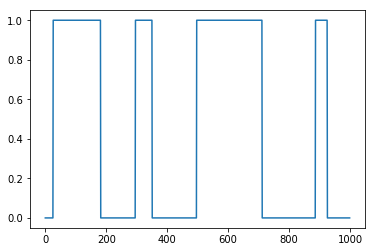

In [4]:
plt.plot(latent_1D);

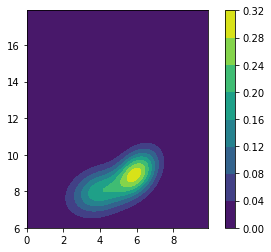

In [5]:
c1 = scipy.stats.multivariate_normal([6,9], [[0.5625, 0.225],[0.225, 0.675]])
c2 = scipy.stats.multivariate_normal([4,8], [[1.125, 0.225],[0.225, 0.675]])

x1, y1 = np.mgrid[-0:10:.1, 6:18:.1]
pos = np.empty(x1.shape + (2,))
pos[:, :, 0] = x1; pos[:, :, 1] = y1
plt.contourf(x1, y1, c1.pdf(pos) + c2.pdf(pos)) # + c3.pdf(pos))
ax = plt.gca()
ax.set_aspect("equal")
plt.colorbar()

## Sample Data

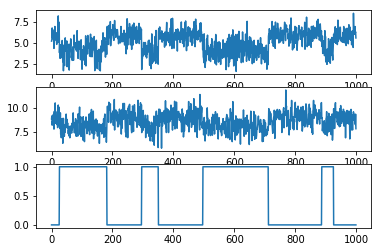

In [6]:
obs = np.empty((len(phys_space[:,0]), 2))
for i,l in enumerate(latent_1D):
    # generate a 2-d random vector at each point
    if l == 0:
        obs[i,:] = c1.rvs()
    elif l == 1:
        obs[i,:] = c2.rvs()
        
fig, ax = plt.subplots(3,1)
ax[0].plot(obs[:,0])
ax[1].plot(obs[:,1])
ax[2].plot(latent_1D)

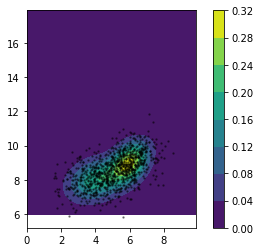

In [7]:
plt.contourf(x1, y1, c1.pdf(pos) + c2.pdf(pos)) # + c3.pdf(pos))
ax = plt.gca()
ax.set_aspect("equal")
plt.colorbar()
plt.scatter(obs[:,0], obs[:,1], c='black', s=2, alpha=0.4)

## Try

In [8]:
ex1 = hmrf_gmm.HMRFGMM2(phys_space, obs)

In [9]:
gibbs_energy = ex1.calc_gibbs_energy(ex1.labels[-1], ex1.betas[-1])
energy_like = ex1.calc_energy_like(ex1.mus[-1], ex1.covs[-1], ex1.labels[-1])
#energy_like_labels = ex1.calc_energy_like_labels(ex1.mus[-1], ex1.covs[-1], ex1.labels[-1])
self_energy = np.array([0., 0.])

In [10]:
ex1.mus[-1][1, :]

array([ 4.00468307,  8.0066839 ])

In [11]:
energy_like[:,1]

array([  9.04859219e-01,   1.60332944e+00,   3.49097559e+00,
         1.15829501e+00,   1.16008198e+00,   8.59036330e-01,
         3.45954398e+00,   1.31285961e+00,  -1.94383426e-01,
         4.69804857e+00,   1.78257066e+00,   4.08644422e+00,
         6.52400597e+00,   1.30225027e+00,   6.31074446e-01,
         2.21993083e+00,   1.46767778e+00,   2.16916528e-01,
         2.00192431e+00,   3.54517170e+00,   3.23872781e-01,
         1.72163038e+00,   1.16726953e+01,   3.75649883e-01,
         5.93262388e+00,   7.69292780e+00,  -1.63061951e-01,
        -1.83004519e-02,   8.65105109e-02,   1.78278918e+00,
         1.81599882e-01,   4.57918083e-02,   9.54158470e-01,
        -1.18904116e-01,   7.29423469e-01,   9.77213462e-01,
        -2.86006430e-01,   2.67863614e+00,   4.79940700e-01,
         2.61043773e+00,  -6.92908749e-02,   9.37686003e-02,
         1.57437933e+00,   1.21818477e+00,   5.70896273e-01,
         1.13255802e+00,   4.43723569e-01,   2.53102710e-01,
         1.37327848e+00,

In [12]:
total_energy = gibbs_energy + energy_like + self_energy

In [13]:
ex1.obs[0,:]

array([ 5.20244236,  8.85937069])

In [14]:
ex1.labels

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [15]:
ex1.gibbs_sample(verbose=True)

labels_prob: [[ 0.62245933  0.37754067]
 [ 0.73105858  0.26894142]
 [ 0.73105858  0.26894142]
 ..., 
 [ 0.73105858  0.26894142]
 [ 0.73105858  0.26894142]
 [ 0.62245933  0.37754067]]
new labels (sum): [0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1
 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0
 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1
 0 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0
 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 0 1 0
 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0
 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1
 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0
 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 

In [16]:
from itertools import combinations

In [17]:
comb = list(combinations(range(ex1.n_obs), 2))

In [18]:
ex1.propose_cov(ex1.covs[-1], 0.00005, 0.005)

array([[[ 0.24191515, -0.53040198],
        [ 0.24240541,  0.43274887]],

       [[-0.81036522, -0.64888971],
        [ 0.78789793,  0.60181037]]])

In [19]:
a = np.eye(2)
a

array([[ 1.,  0.],
       [ 0.,  1.]])

In [20]:
rot = np.array([[ 0.61895508, -1.10357645], [-0.89642355,  0.53960692]])

In [21]:
v_l = [[-0.73529683, -0.67774522],
 [-0.67774522,  0.73529683]]

In [22]:
rot * a

array([[ 0.61895508, -0.        ],
       [-0.        ,  0.53960692]])

In [23]:
np.matmul(rot, a)

array([[ 0.61895508, -1.10357645],
       [-0.89642355,  0.53960692]])

In [24]:
np.matmul(a, rot)

array([[ 0.61895508, -1.10357645],
       [-0.89642355,  0.53960692]])

In [25]:
d_j = [ 0.01019377, -0.00136439]

In [26]:
np.log(d_j)

C:\Users\Alexander\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


array([-4.58597853,         nan])

In [27]:
np.diag(d_j)

array([[ 0.01019377,  0.        ],
       [ 0.        , -0.00136439]])

In [28]:
comb

[(0, 1)]

In [29]:
n_axis = len(comb)

In [30]:
n_axis

1

In [31]:
for i in range(n_axis):
    print(V[:,comb[i][0]])

NameError: name 'V' is not defined

In [ ]:
V

In [ ]:
np.zeros_like(cov)[]

In [ ]:
comb[2][1]

In [ ]:
np.ones((3)) * 0.005

In [ ]:
cov = ex1.covs[-1]

In [ ]:
A,B,C = np.linalg.svd(cov)

In [ ]:
multivariate_normal(mean=[0 for i in range(1)], cov=np.ones(1)*0.005).rvs()

In [ ]:
V,D,V = np.linalg.svd(cov[0, :, :])

In [ ]:
V

In [ ]:
D

In [ ]:
np.vstack((D,D))

In [ ]:
multivariate_normal(mean=[0 for i in range(ex1.n_obs)], cov=np.eye(ex1.n_obs) * 0.00005).rvs()